In [16]:
import os
import cv2
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import glob
import random
import torch
from torch.utils.data import Dataset, DataLoader

# **Preprocessing**

In [8]:
images_dir = "archive (3)/brats18/images"
masks_dir = "archive (3)/brats18/masks"

image_files = sorted(glob.glob(os.path.join(images_dir, "image_*.png")))
print(f"Found {len(image_files)} image files: {image_files}")

mask_files = sorted(glob.glob(os.path.join(masks_dir, "mask_*.png")))
print(f"Found {len(mask_files)} mask files: {mask_files}")

Found 5042 image files: ['archive (3)/brats18/images\\image_1.png', 'archive (3)/brats18/images\\image_10.png', 'archive (3)/brats18/images\\image_100.png', 'archive (3)/brats18/images\\image_1000.png', 'archive (3)/brats18/images\\image_1001.png', 'archive (3)/brats18/images\\image_1002.png', 'archive (3)/brats18/images\\image_1003.png', 'archive (3)/brats18/images\\image_1004.png', 'archive (3)/brats18/images\\image_1005.png', 'archive (3)/brats18/images\\image_1006.png', 'archive (3)/brats18/images\\image_1007.png', 'archive (3)/brats18/images\\image_1008.png', 'archive (3)/brats18/images\\image_1009.png', 'archive (3)/brats18/images\\image_101.png', 'archive (3)/brats18/images\\image_1010.png', 'archive (3)/brats18/images\\image_1011.png', 'archive (3)/brats18/images\\image_1012.png', 'archive (3)/brats18/images\\image_1013.png', 'archive (3)/brats18/images\\image_1014.png', 'archive (3)/brats18/images\\image_1015.png', 'archive (3)/brats18/images\\image_1016.png', 'archive (3)/bra

In [9]:
assert len(image_files) == len(mask_files), "Mismatch between images and masks!"

In [10]:
# Preprocessing function: grayscale, normalize, enhance contrast, resize
def preprocess_image(file_path, target_size=(112, 112)):
    image = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
    image = image.astype(np.float32) / 255.0
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    image = clahe.apply((image * 255).astype(np.uint8)) / 255.0
    image = cv2.resize(image, target_size)
    return image

In [11]:
# Shuffle and split data into training and validation sets (80/20)
combined = list(zip(image_files, mask_files))
random.shuffle(combined)
split_idx = int(len(combined) * 0.8)
train_pairs = combined[:split_idx]
val_pairs = combined[split_idx:]

In [12]:
# Apply preprocessing
train_images = [preprocess_image(img_path) for img_path, _ in train_pairs]
train_masks = [cv2.resize(cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE), (240, 240)) for _, mask_path in train_pairs]
val_images = [preprocess_image(img_path) for img_path, _ in val_pairs]
val_masks = [cv2.resize(cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE), (240, 240)) for _, mask_path in val_pairs]

print(f"Sample preprocessed image shape: {train_images[0].shape}")
print(f"Sample mask shape: {train_masks[0].shape}")

Sample preprocessed image shape: (112, 112)
Sample mask shape: (240, 240)


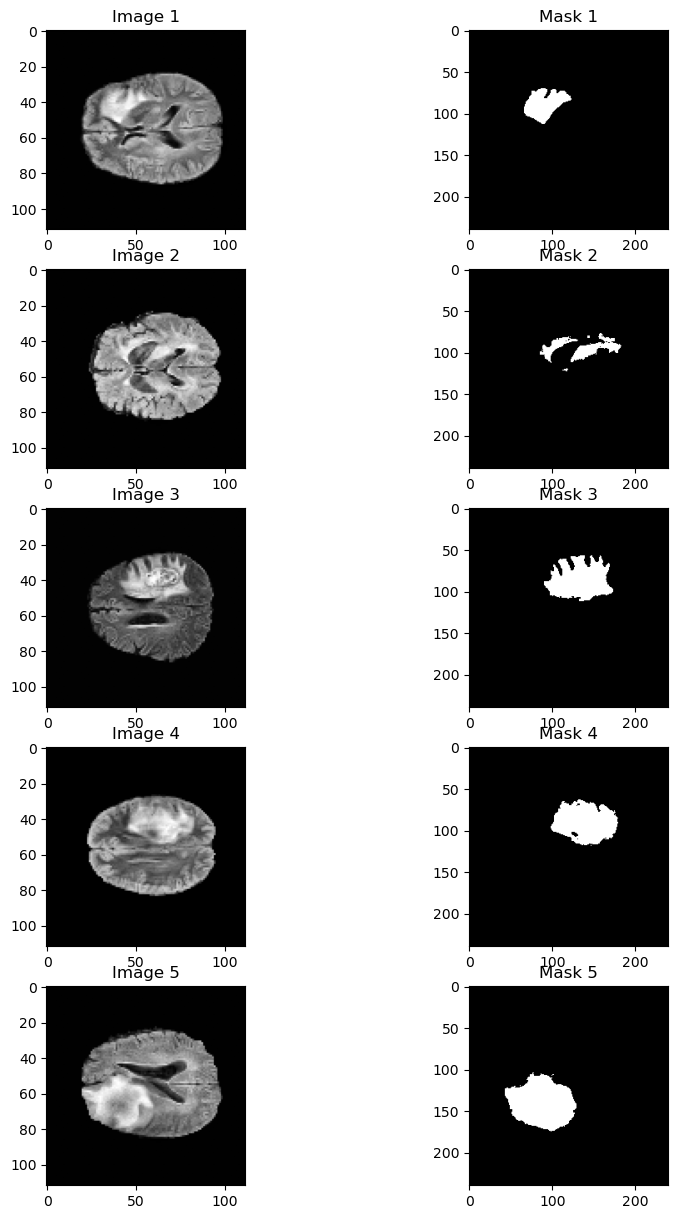

In [52]:
# Function to display sample images and their corresponding masks
def display_sample_images(images, masks, n_samples=5):
    fig, axes = plt.subplots(n_samples, 2, figsize=(10, 15))
    for i in range(n_samples):
        axes[i, 0].imshow(images[i], cmap='gray')
        axes[i, 0].set_title(f"Image {i+1}")
        axes[i, 1].imshow(masks[i], cmap='gray')
        axes[i, 1].set_title(f"Mask {i+1}")
    plt.show()

display_sample_images(train_images, train_masks)

# **save preprocessed data**

In [56]:
def save_image(image, save_path):
    image_to_save = (image * 255).astype(np.uint8)
    cv2.imwrite(save_path, image_to_save)
    print(f"Saved image to {save_path}")

def save_mask(mask, save_path):
    mask_to_save = mask.astype(np.uint8)
    cv2.imwrite(save_path, mask_to_save)
    print(f"Saved mask to {save_path}")

def save_preprocessed_images(images, masks, image_save_dir, mask_save_dir, prefix="train"):
    os.makedirs(image_save_dir, exist_ok=True)
    os.makedirs(mask_save_dir, exist_ok=True)

    for idx, (image, mask) in enumerate(zip(images, masks)):
        image_save_path = os.path.join(image_save_dir, f"{prefix}_image_{idx}.png")
        mask_save_path = os.path.join(mask_save_dir, f"{prefix}_mask_{idx}.png")
        
        save_image(image, image_save_path)
        save_mask(mask, mask_save_path)
        
train_image_save_dir = "preprocessed_images/train_images"
train_mask_save_dir = "preprocessed_images/train_masks"
val_image_save_dir = "preprocessed_images/val_images"
val_mask_save_dir = "preprocessed_images/val_masks"

save_preprocessed_images(train_images, train_masks, train_image_save_dir, train_mask_save_dir, prefix="train")
save_preprocessed_images(val_images, val_masks, val_image_save_dir, val_mask_save_dir, prefix="val")

Saved image to preprocessed_images/train_images\train_image_0.png
Saved mask to preprocessed_images/train_masks\train_mask_0.png
Saved image to preprocessed_images/train_images\train_image_1.png
Saved mask to preprocessed_images/train_masks\train_mask_1.png
Saved image to preprocessed_images/train_images\train_image_2.png
Saved mask to preprocessed_images/train_masks\train_mask_2.png
Saved image to preprocessed_images/train_images\train_image_3.png
Saved mask to preprocessed_images/train_masks\train_mask_3.png
Saved image to preprocessed_images/train_images\train_image_4.png
Saved mask to preprocessed_images/train_masks\train_mask_4.png
Saved image to preprocessed_images/train_images\train_image_5.png
Saved mask to preprocessed_images/train_masks\train_mask_5.png
Saved image to preprocessed_images/train_images\train_image_6.png
Saved mask to preprocessed_images/train_masks\train_mask_6.png
Saved image to preprocessed_images/train_images\train_image_7.png
Saved mask to preprocessed_imag

# **Load the Preprocessed Data**

In [57]:
class BrainTumorDataset(Dataset):
    def __init__(self, images_dir, masks_dir, transform=None):
        self.image_paths = sorted([os.path.join(images_dir, f) for f in os.listdir(images_dir)])
        self.mask_paths = sorted([os.path.join(masks_dir, f) for f in os.listdir(masks_dir)])
        self.transform = transform
        
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        image = cv2.imread(self.image_paths[idx], cv2.IMREAD_GRAYSCALE)
        mask = cv2.imread(self.mask_paths[idx], cv2.IMREAD_GRAYSCALE)
        
        image = image.astype(np.float32) / 255.0
        mask = mask.astype(np.float32) / 255.0  

        
        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)
        
        return torch.tensor(image, dtype=torch.float32).unsqueeze(0), torch.tensor(mask, dtype=torch.float32).unsqueeze(0)


In [58]:
train_image_dir = "preprocessed_images/train_images"
train_mask_dir = "preprocessed_images/train_masks"
val_image_dir = "preprocessed_images/val_images"
val_mask_dir = "preprocessed_images/val_masks"

train_dataset = BrainTumorDataset(train_image_dir, train_mask_dir)
val_dataset = BrainTumorDataset(val_image_dir, val_mask_dir)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

sample_images, sample_masks = next(iter(train_loader))
print(f"Sample image shape: {sample_images.shape}, Sample mask shape: {sample_masks.shape}")

Sample image shape: torch.Size([32, 1, 112, 112]), Sample mask shape: torch.Size([32, 1, 240, 240])


# **EDA**

## **Visualize sample images with their Masks**

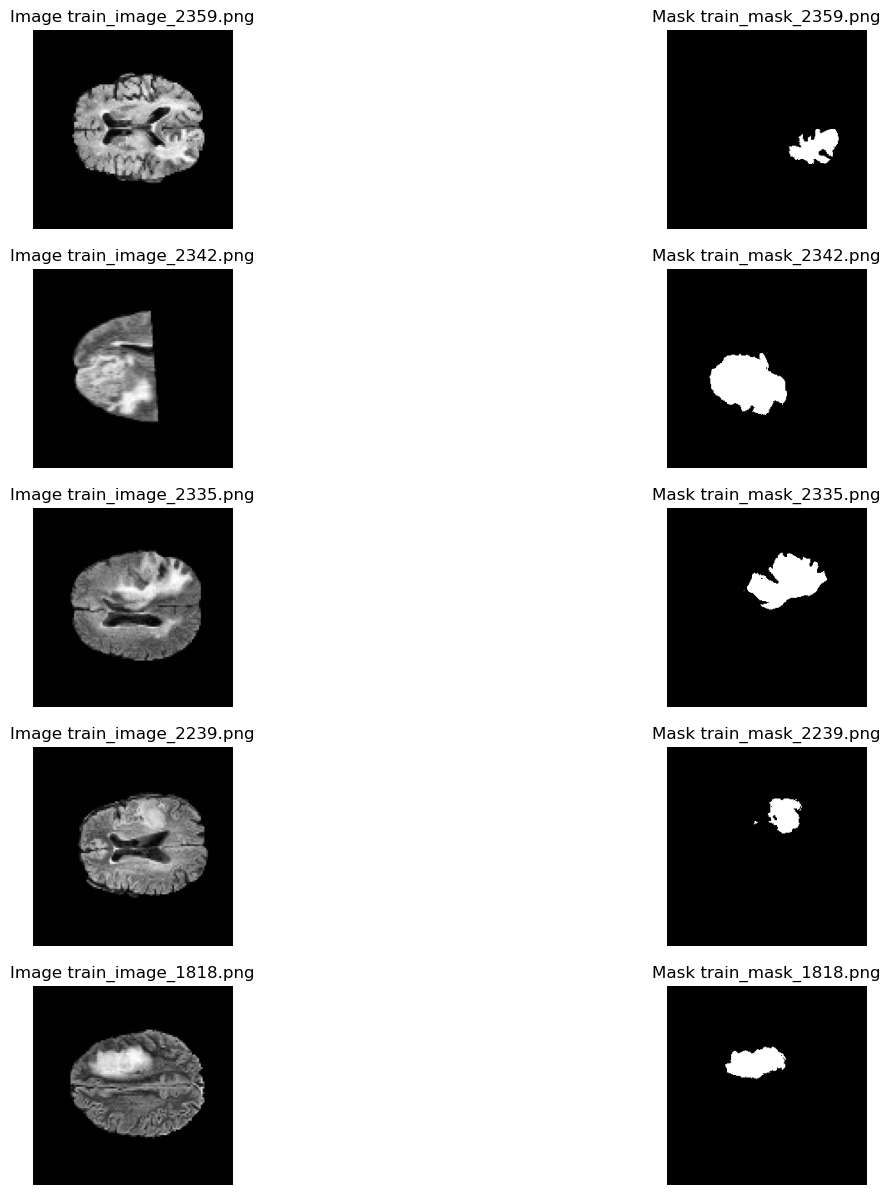

In [21]:
def visualize_sample_images(image_dir, mask_dir, num_samples=5):
    image_files = sorted(os.listdir(image_dir))
    mask_files = sorted(os.listdir(mask_dir))
    
    sample_images = random.sample(image_files, num_samples)
    
    plt.figure(figsize=(15, 15))
    
    for idx, img_name in enumerate(sample_images):
        img_path = os.path.join(image_dir, img_name)
        mask_path = os.path.join(mask_dir, mask_files[image_files.index(img_name)])
        
        image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        
        plt.subplot(num_samples, 2, 2 * idx + 1)
        plt.imshow(image, cmap='gray')
        plt.title(f"Image {img_name}")
        plt.axis('off')
        
        plt.subplot(num_samples, 2, 2 * idx + 2)
        plt.imshow(mask, cmap='gray')
        plt.title(f"Mask {mask_files[image_files.index(img_name)]}")
        plt.axis('off')
    
    plt.show()

visualize_sample_images("preprocessed_images/train_images", "preprocessed_images/train_masks", num_samples=5)


## **Plot histogram for a sample Image**

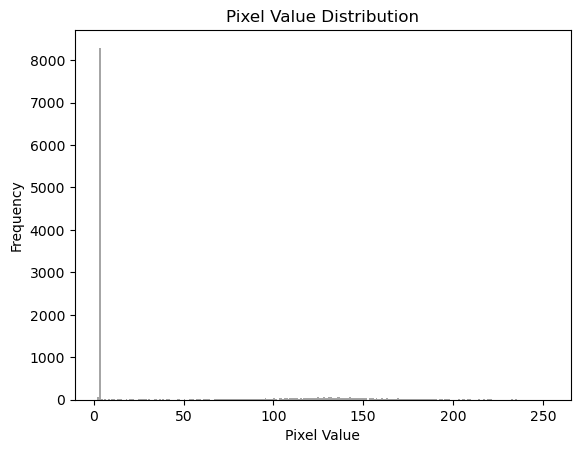

In [24]:
def plot_pixel_histogram(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    plt.hist(image.ravel(), bins=256, color='gray', alpha=0.7)
    plt.title('Pixel Value Distribution')
    plt.xlabel('Pixel Value')
    plt.ylabel('Frequency')
    plt.show()

plot_pixel_histogram("preprocessed_images/train_images/train_image_0.png")

# **Feature Engineering**

In [59]:
from skimage import measure
from skimage.feature import graycomatrix, graycoprops

In [68]:
def extract_statistical_features(image, mask):
    tumor_pixels = image[mask > 0]
    return {
        "mean_intensity": np.mean(tumor_pixels),
        "std_intensity": np.std(tumor_pixels),
        "skewness": float(np.mean((tumor_pixels - np.mean(tumor_pixels))**3)) / (np.std(tumor_pixels)**3 + 1e-6),
        "kurtosis": float(np.mean((tumor_pixels - np.mean(tumor_pixels))**4)) / (np.std(tumor_pixels)**4 + 1e-6),
    }

def extract_shape_features(mask):
    labeled_mask = measure.label(mask)
    props = measure.regionprops(labeled_mask)
    if not props:
        return {}
    tumor = props[0]
    return {
        "area": tumor.area,
        "perimeter": tumor.perimeter,
        "eccentricity": tumor.eccentricity,
        "solidity": tumor.solidity,
        "extent": tumor.extent,
        "compactness": (tumor.perimeter ** 2) / (tumor.area + 1e-6),
    }

def extract_texture_features(image, mask, distances=[1], angles=[0]):
    masked_image = cv2.bitwise_and(image, image, mask=mask.astype(np.uint8))
    image_clipped = np.clip(masked_image, 0, 255).astype(np.uint8)
    image_quantized = (image_clipped / 32).astype(np.uint8)
    glcm = graycomatrix(image_quantized, distances=distances, angles=angles, symmetric=True, normed=True)
    features = {
        "glcm_contrast": graycoprops(glcm, 'contrast')[0, 0],
        "glcm_correlation": graycoprops(glcm, 'correlation')[0, 0],
        "glcm_energy": graycoprops(glcm, 'energy')[0, 0],
        "glcm_homogeneity": graycoprops(glcm, 'homogeneity')[0, 0]
    }
    return features

def extract_features(image, mask):
    features = {}
    features.update(extract_statistical_features(image, mask))
    features.update(extract_shape_features(mask))
    features.update(extract_texture_features(image, mask))
    return features

Mask min: 0, max: 1
Extracted Features: {'mean_intensity': 202.859477124183, 'std_intensity': 29.879877019609587, 'skewness': -0.6936532064652616, 'kurtosis': 3.2633583997252074, 'area': 306.0, 'perimeter': 85.49747468305833, 'eccentricity': 0.7689977776713746, 'solidity': 0.8453038674033149, 'extent': 0.5666666666666667, 'compactness': 23.888294618600998, 'glcm_contrast': 0.10666023166023167, 'glcm_correlation': 0.9369196544280726, 'glcm_energy': 0.9733414191814803, 'glcm_homogeneity': 0.9914150210851325}


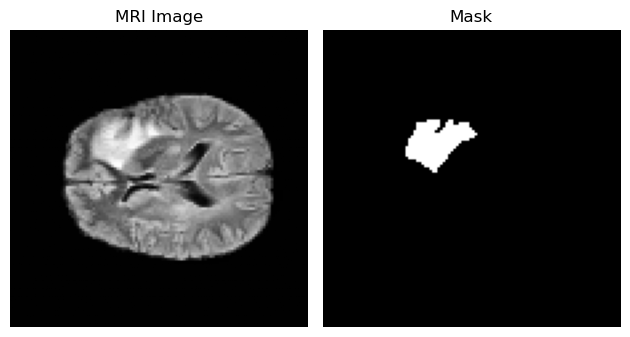

In [70]:
image = cv2.imread(r"preprocessed_images/train_images\train_image_0.png", cv2.IMREAD_GRAYSCALE)
mask = cv2.imread(r"preprocessed_images/train_masks\train_mask_0.png", cv2.IMREAD_GRAYSCALE)

if image is None or mask is None:
    raise FileNotFoundError("Failed to load image or mask. Check file paths.")

mask = cv2.resize(mask, (112, 112), interpolation=cv2.INTER_NEAREST)
mask = (mask > 127).astype(np.uint8)

print(f"Mask min: {np.min(mask)}, max: {np.max(mask)}")

features = extract_features(image, mask)
print("Extracted Features:", features)

plt.subplot(1, 2, 1)
plt.title("MRI Image")
plt.imshow(image, cmap='gray')
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title("Mask")
plt.imshow(mask, cmap='gray', vmin=0, vmax=1)
plt.axis("off")

plt.tight_layout()
plt.show()